# nb005

**colabでは png, jpeg などのファイルの読み込みが遅い**

**[このqiita記事](https://qiita.com/rio53/items/5cbdf6d92f3adc17953e)によるとバイナリファイルの構造を用いたHDF５ファイル構造を用いることで圧倒的に読み込みが速くなったらしい**
**compressionを設定しないとファイルサイズが馬鹿でかくなる**
* maskしたdataづくり
* [UWMGI: Mask Data](https://www.kaggle.com/code/awsaf49/uwmgi-mask-data) (これは結局参考にしてない)
* [AW-Madison: EDA & In Depth Mask Exploration](https://www.kaggle.com/code/andradaolteanu/aw-madison-eda-in-depth-mask-exploration)を参照
* 2D mask data
* visualization

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
%cd /content/drive/MyDrive/kaggle/UWMGI/

# シンボリックリンクを作成
!ln -sfn /content/drive/MyDrive/kaggle/UWMGI/ /content/workspace
# install vim
!apt-get install vim
# kaggle api
!pip install kaggle
#!wandb login $WANDB_API_KEY

# current directory 変更
import os
# path を通す
import sys
sys.path.append("../")

# import したもの自動reloadする設定
%load_ext autoreload
%autoreload 2

os.environ["KAGGLE_CONFIG_DIR"] = "/content/workspace"

In [2]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
import os
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed
import glob
import pdb
import h5py

# visualization
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
# --- Custom Color Maps ---
# Yellow Purple Red
labels = ["Large Bowel", "Small Bowel", "Stomach"]

from matplotlib.colors import LinearSegmentedColormap
# Custom color map in matplotlib
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

In [3]:
train = pd.read_csv("./data/train.csv")
train_id = train["id"].str.split("_")

train["case"] = train_id.str.get(0).str.replace("case", "")
train["day"] = train_id.str.get(1).str.replace("day", "")
train["slice"] = train["id"].str.split("_").str.get(-1)
train.head()

id        class segmentation case day slice
0  case123_day20_slice_0001  large_bowel          NaN  123  20  0001
1  case123_day20_slice_0001  small_bowel          NaN  123  20  0001
2  case123_day20_slice_0001      stomach          NaN  123  20  0001
3  case123_day20_slice_0002  large_bowel          NaN  123  20  0002
4  case123_day20_slice_0002  small_bowel          NaN  123  20  0002

In [4]:
def id2image_path(df, base_path):
    """
    input: dataframe
    output: add "path" columns to the dataframe
    dfに対応するpathのcolumnを追加
    """
    res = np.array([])
    for idx in tqdm(range(df.shape[0])):
        row = df.iloc[idx, :]
        case_num = row["case"]
        day_num = row["day"]
        slice_num = row["slice"]
        rough_file_path = f"{base_path}/case{case_num}/case{case_num}_day{day_num}/scans/slice_{slice_num}*"
        path = glob.glob(rough_file_path)[0]
        res = np.append(res, path)
    
    df["path"] = res
    return df

train = id2image_path(train, "./data/train")

  0%|          | 0/115488 [00:00<?, ?it/s]

In [5]:
size_info = train["path"].str.split("/").str.get(-1).str.split("_")
train["image_height"] = size_info.str.get(2)
train["image_height"] = train["image_height"].astype(int)
train["image_width"] = size_info.str.get(3)
train["image_width"] = train["image_width"].astype(int)
train["pixel_height"] = size_info.str.get(4)
train["pixel_height"] = train["pixel_height"].astype(float)
train["pixel_width"] = size_info.str.get(-1).str.replace(".png", "")
train["pixel_width"] = train["pixel_width"].astype(float)

device_info = {"0": [234, 234], "1": [266, 266], "2": [276, 276], "3": [360, 310]}
train["device_type"] = -1
for k, (h, w) in device_info.items():
    mask = (train["image_height"] == h) & (train["image_width"] == w)
    train.loc[mask, "device_type"] = k
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


id        class segmentation case day slice  \
0  case123_day20_slice_0001  large_bowel          NaN  123  20  0001   
1  case123_day20_slice_0001  small_bowel          NaN  123  20  0001   
2  case123_day20_slice_0001      stomach          NaN  123  20  0001   
3  case123_day20_slice_0002  large_bowel          NaN  123  20  0002   
4  case123_day20_slice_0002  small_bowel          NaN  123  20  0002   

                                                path  image_height  \
0  ./data/train/case123/case123_day20/scans/slice...           266   
1  ./data/train/case123/case123_day20/scans/slice...           266   
2  ./data/train/case123/case123_day20/scans/slice...           266   
3  ./data/train/case123/case123_day20/scans/slice...           266   
4  ./data/train/case123/case123_day20/scans/slice...           266   

   image_width  pixel_height  pixel_width device_type  
0          266           1.5          1.5           1  
1          266           1.5          1.5           1  
2          266           1.5          1.5           1  
3          266           1.5          1.5           1  
4          266           1.5          1.5           1

In [6]:
def read_image(path):
    """
    intput path: str
    output image: numpy array
    """
    image = cv.imread(path, cv.IMREAD_UNCHANGED).astype("float32")
    # Scale to [0, 255]
    image = cv.normalize(image, None, alpha = 0, beta = 255, 
                        norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
    image = image.astype(np.uint8)
    return image

In [7]:
def show_simple_images(sample_paths):
    """
    input sample_paths: list of paths
    output figure
    """
    # get meta data from path
    case_name = [info.split("_")[0][-7:] for info in sample_paths]
    day_name = [info.split("_")[1].split("/")[0] for info in sample_paths]
    slice_name = [info.split("_")[2] for info in sample_paths]

    # plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 8))
    axs = axs.flatten()
    for k, path in enumerate(sample_paths):
        title = f"{k+1}. {case_name[k]} - {day_name[k]} - {slice_name[k]}"
        axs[k].set_title(title, fontsize = 14, weight='bold')
        img = read_image(path)
        axs[k].imshow(img)
        axs[k].axis("off")
    fig.tight_layout()
    fig.show()

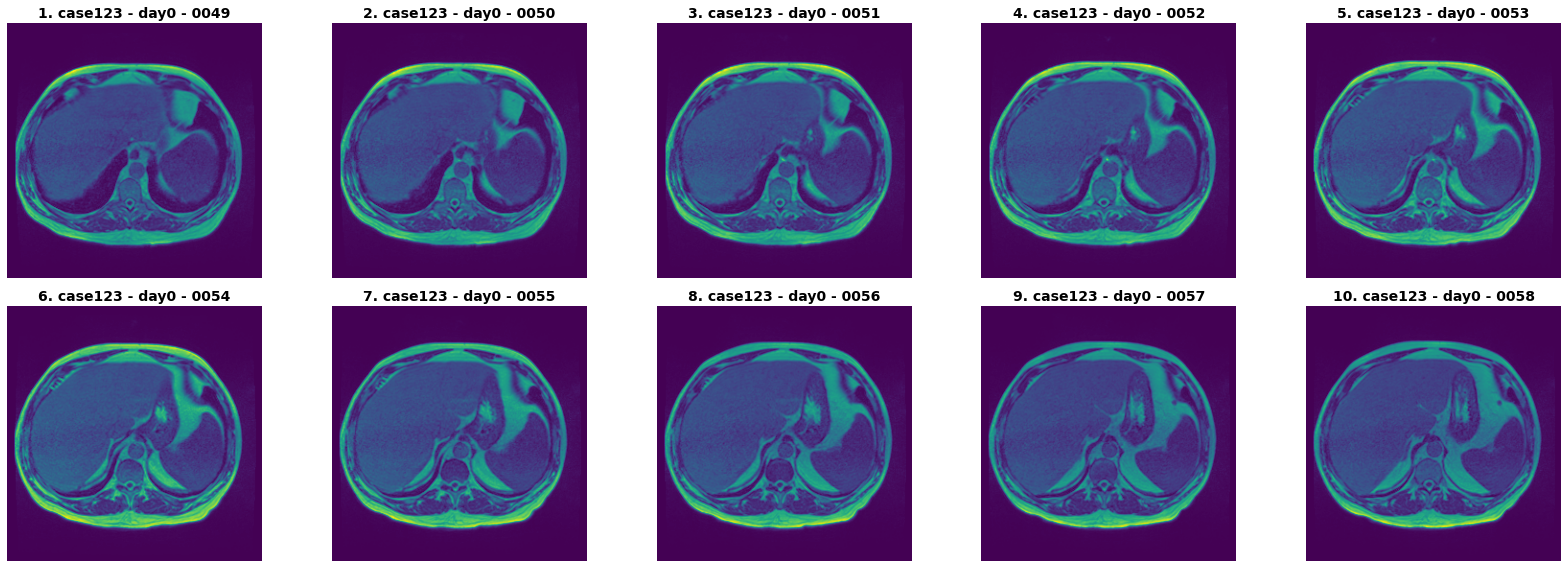

In [8]:
CASE = "123"

# Sample a few images from speciffied case
sample_paths1 = train[(train["segmentation"].isna()==False) & (train["case"]==CASE)]["path"]\
                .reset_index().groupby("path")["index"].count()\
                .reset_index().loc[:9, "path"].tolist()

show_simple_images(sample_paths1)

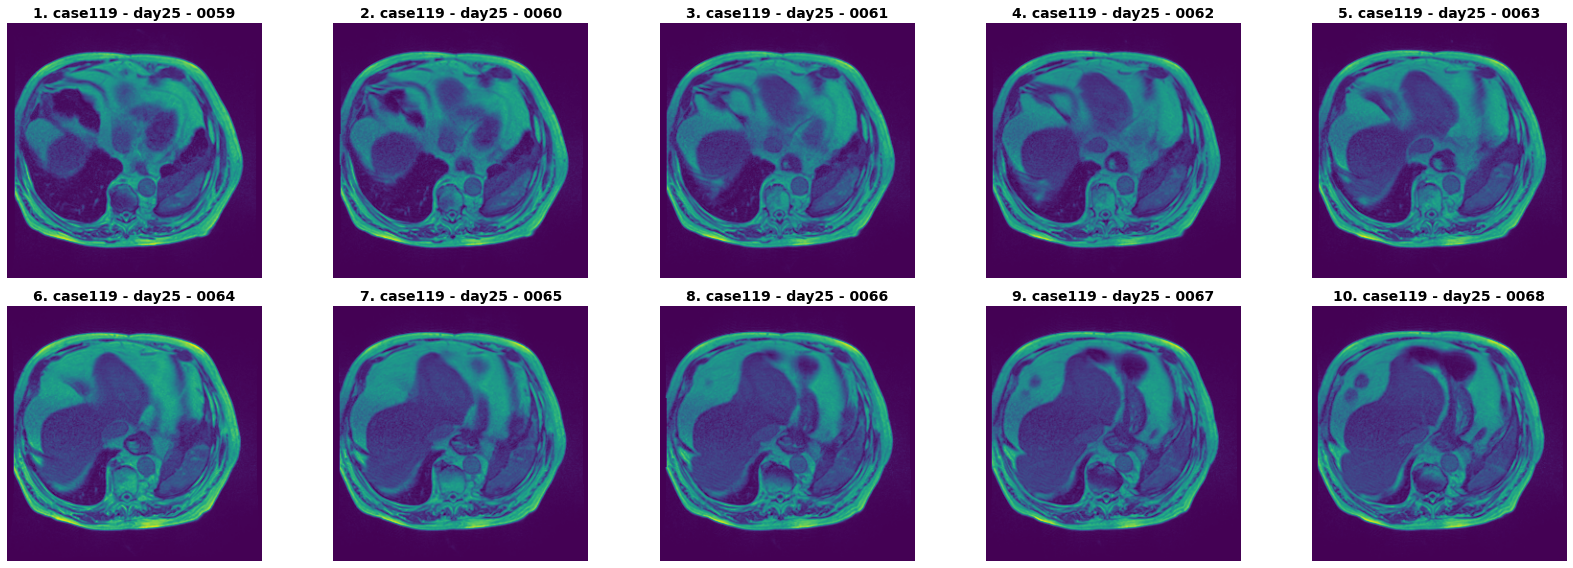

In [9]:
DAY = "25"

# Sample a few images from speciffied case
sample_paths2 = train[(train["segmentation"].isna()==False) & (train["day"]==DAY)]["path"]\
                .reset_index().groupby("path")["index"].count()\
                .reset_index().loc[:9, "path"].tolist()

show_simple_images(sample_paths2)

In [10]:
def mask_from_segmentation(segmentation, shape):
    """
    Return the mask corresponging to the inputed segmentation
    segmentation: list of start points and length in this order
    shape: the shape to be taken by the mask
    return : 2D mask
    """
    segm = np.asarray(segmentation.split(), dtype=int)
    # 0-index
    start_point = segm[0::2] - 1
    length_point = segm[1::2]

    end_point = start_point + length_point

    case_mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 1
    
    case_mask = case_mask.reshape((shape[0], shape[1]))
    return case_mask

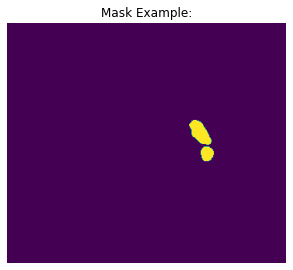

In [11]:
# test
segmentation = '45601 5 45959 10 46319 12 46678 14 47037 16 47396 18 47756 18 48116 19 48477 18 48837 19 \
                49198 19 49558 19 49919 19 50279 20 50639 20 50999 21 51359 21 51719 22 52079 22 52440 22 52800 22 53161 21 \
                53523 20 53884 20 54245 19 54606 19 54967 18 55328 17 55689 16 56050 14 56412 12 56778 4 57855 7 58214 9 58573 12 \
                58932 14 59292 15 59651 16 60011 17 60371 17 60731 17 61091 17 61451 17 61812 15 62172 15 62532 15 62892 14 \
                63253 12 63613 12 63974 10 64335 7'

shape = (310, 360)

case_mask = mask_from_segmentation(segmentation, shape)

plt.figure(figsize=(5, 5))
plt.title("Mask Example:")
plt.imshow(case_mask)
plt.axis("off")
plt.show();

In [12]:
def get_id_mask(ID):
    '''Returns a mask for each case ID. If no segmentation was found, the mask will be empty
    - meaning formed by only 0
    ID: the case ID from the train.csv file
    verbose: True if we want any prints
    return: segmentation mask
    IDの部分からclass: large_bowel, small_bowel, stomachを見てsegmentationあればそれをもとにmaskをつくる
    '''

    # ~~~ Get the data ~~~
    # Get the portion of dataframe where we have ONLY the speciffied ID
    ID_data = train[train["id"]==ID].reset_index(drop=True)

    # Split the dataframe into 3 series of observations
    # each for one speciffic class - "large_bowel", "small_bowel", "stomach"
    observations = [ID_data.loc[k, :] for k in range(3)]


    # ~~~ Create the mask ~~~
    # Get the maximum height out of all observations
    # if max == 0 then no class has a segmentation
    # otherwise we keep the length of the mask
    max_height = np.max([obs.image_height for obs in observations])
    max_width = np.max([obs.image_width for obs in observations])

    # Get shape of the image
    # 3 channels of color/classes
    shape = (max_width, max_height, 3)

    # Create an empty mask with the shape of the image
    mask = np.zeros(shape, dtype=np.uint8)

    for k, location in enumerate(["large_bowel", "small_bowel", "stomach"]):
        observation = observations[k]
        segmentation = observation.segmentation

        # If a segmentation is found
        # Append a new channel to the mask
        if pd.isnull(segmentation) == False:
            mask[..., k] = mask_from_segmentation(segmentation, shape)
            
    return mask

In [13]:
# Full Example

# Read image
path = './data/train/case131/case131_day0/scans/slice_0066_360_310_1.50_1.50.png'
img = read_image(path)

# Get mask
ID = "case131_day0_slice_0066"
mask = get_id_mask(ID)

In [14]:
def plot_original_mask(img, mask, alpha=1):

    # Change pixels - when 1 make True, when 0 make NA
    mask = np.where(mask == 1, mask, np.nan)

    # Split the channels
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]


    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Original
    ax1.set_title("Original Image")
    ax1.imshow(img)
    ax1.axis("off")

    # With Mask
    ax2.set_title("Image with Mask")
    ax2.imshow(img)
    ax2.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
#     fig.savefig('foo.png', dpi=500)
    fig.show()

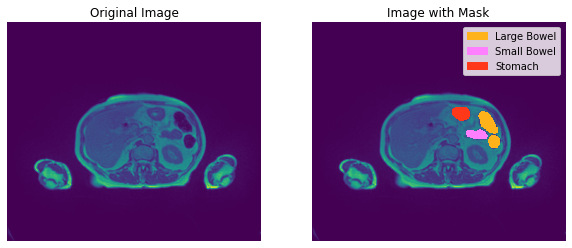

In [15]:
plot_original_mask(img, mask, alpha=1)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


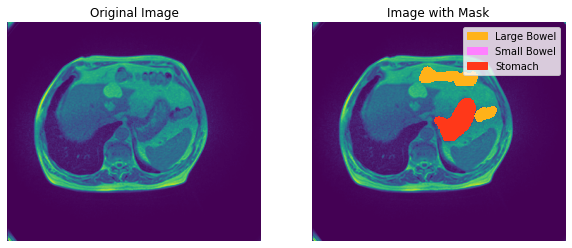

In [16]:
# Another example
path = './data/train/case18/case18_day0/scans/slice_0069_360_310_1.50_1.50.png'
img = read_image(path)

ID = "case18_day0_slice_0069"
mask = get_id_mask(ID)

plot_original_mask(img, mask, alpha=1)

In [17]:
# Filter out all instances with no segmentation
# segmentationないやつ無視
data = train[train["segmentation"].isna()==False].reset_index(drop=True)

In [18]:
def plot_masks_chronologic(imgs, masks, ids, alpha=1):
    """
    imgs: list of images
    masks: list of masks
    ids: list of slices to get meta data(slice number)
    """
    slices = [i.split("_")[-1] for i in ids]
    
    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 11))
    axs = axs.flatten()
    
    for k, (img, mask) in enumerate(zip(imgs, masks)):

        # Change pixels - when 1 make True, when 0 make NA
        mask = np.where(mask == 1, mask, np.nan)

        # Split the channels
        mask_largeB = mask[:, :, 0]
        mask_smallB = mask[:, :, 1]
        mask_stomach = mask[:, :, 2]
        
        title = f"{k+1}. Slice {slices[k]}"
        axs[k].set_title(title, fontsize = 16, 
                         color = "green", weight='bold')

        axs[k].imshow(img, cmap="gist_gray")
        axs[k].axis("off")
        axs[k].imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
        axs[k].imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
        axs[k].imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
        axs[k].axis("off")
    
    axs[0].legend(legend_colors, labels, loc=2)
    fig.tight_layout()
    fig.show()

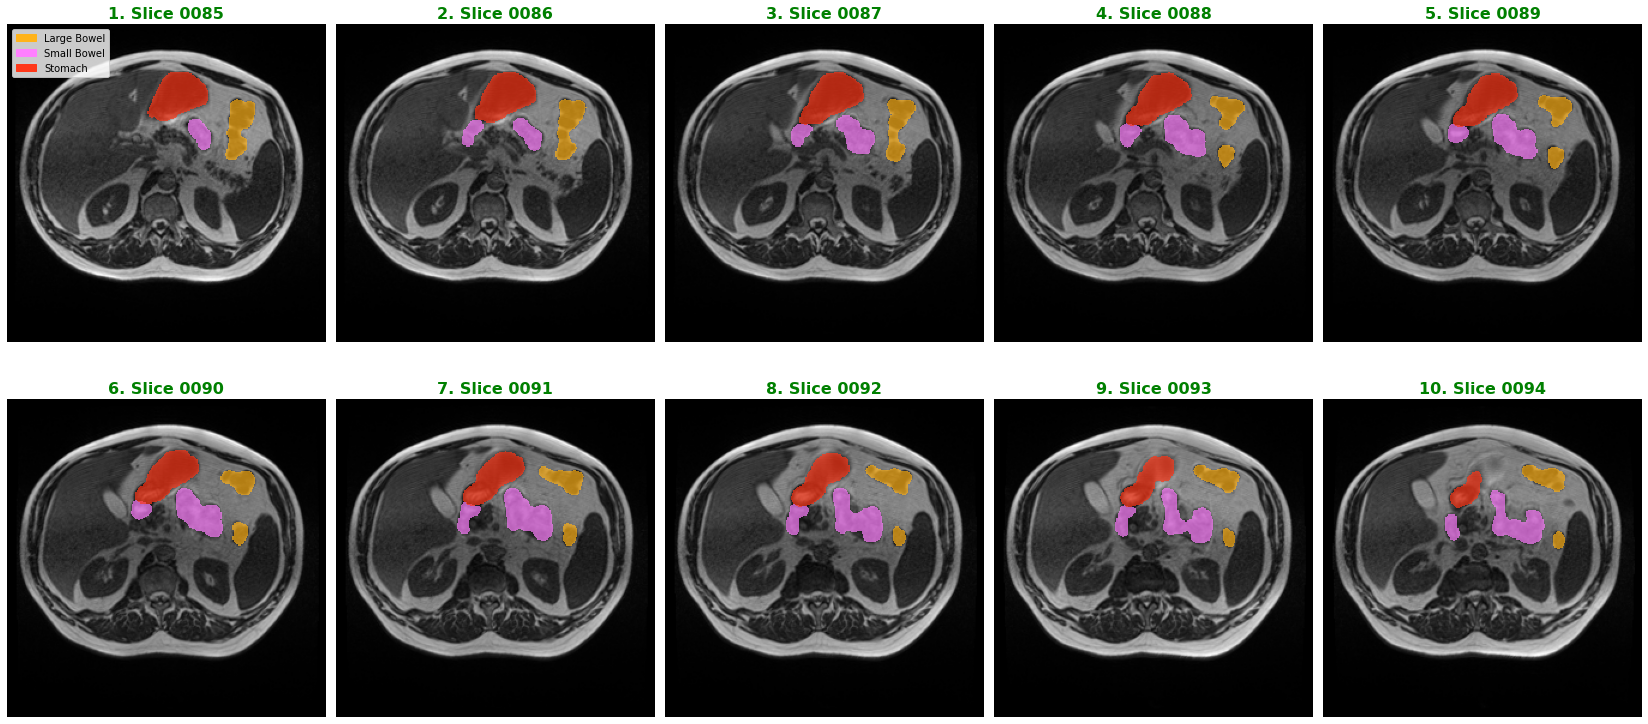

In [19]:
# Get random case
case = "123"
day="20"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().loc[20:29, :]

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


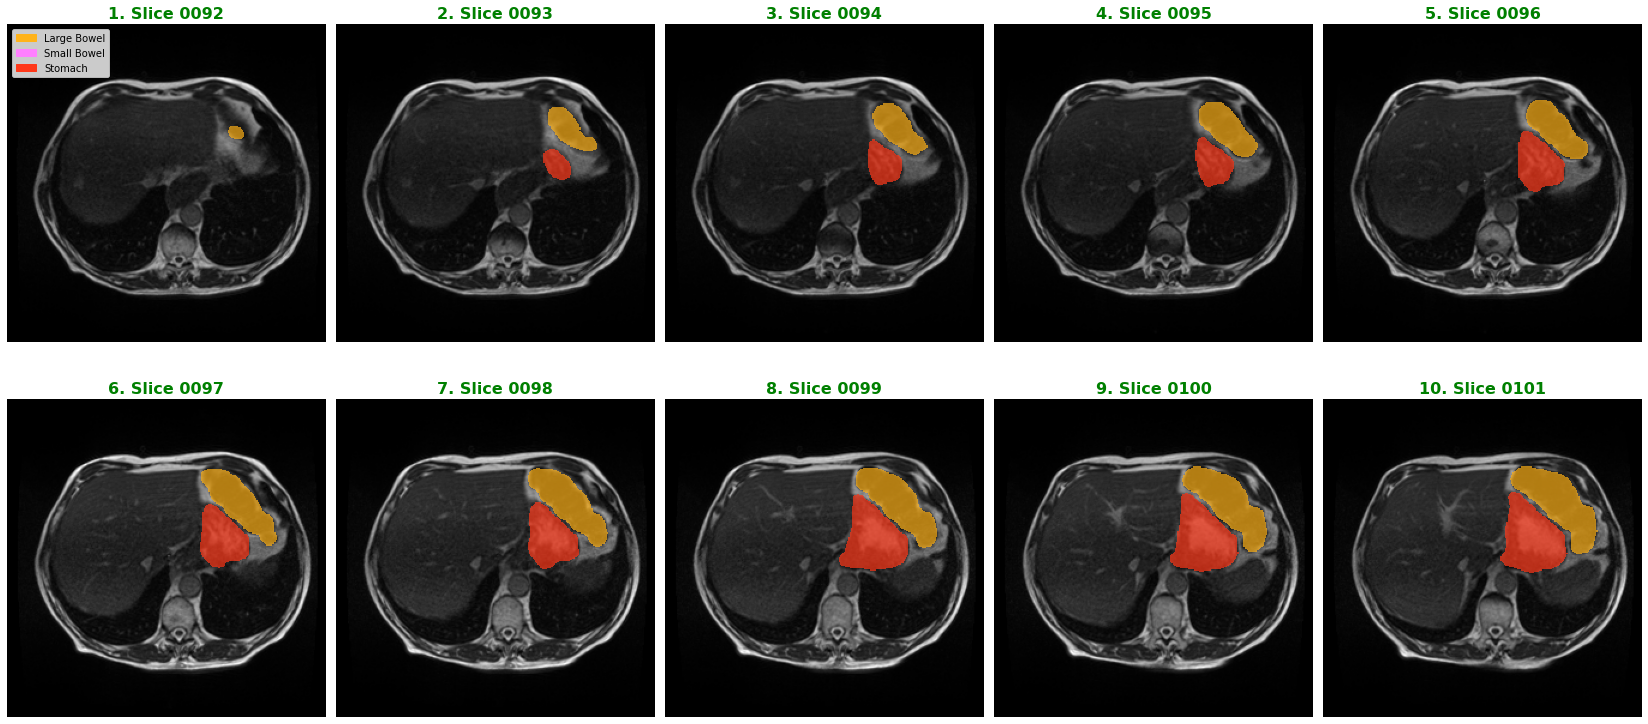

In [20]:
# Get random case
case = "30"
day="0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().head(10)

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


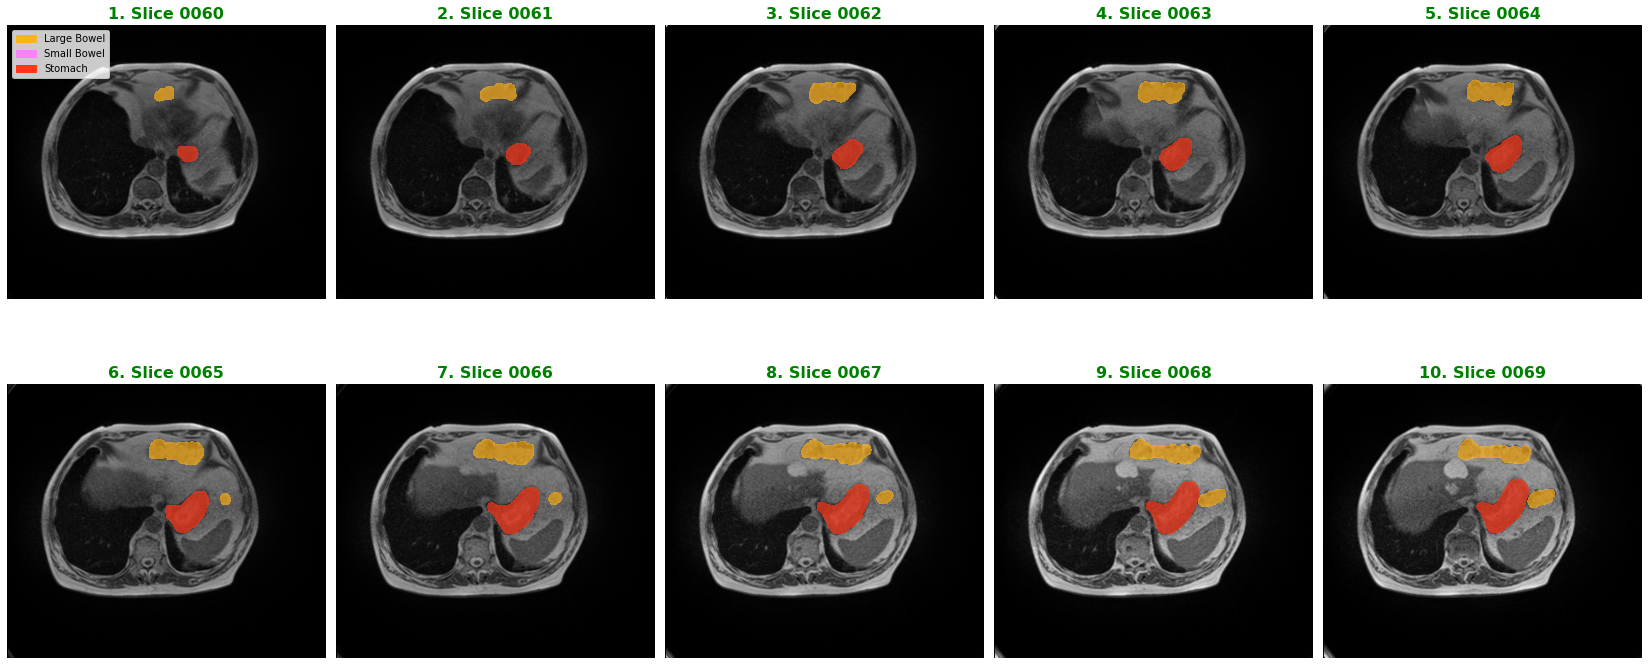

In [21]:
# Get random case
case = "18"
day="0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().head(10)

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


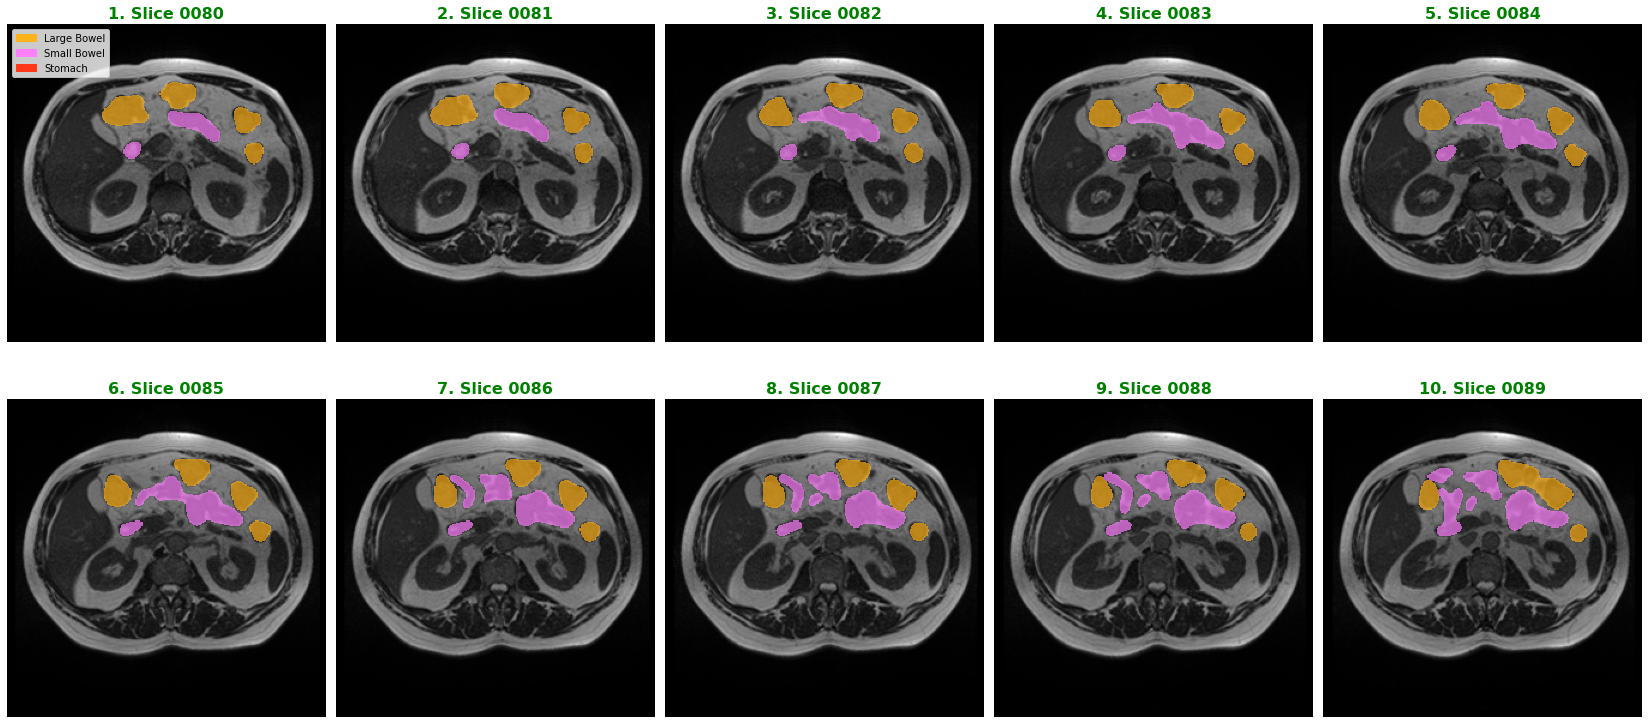

In [22]:
# Get random case
case = "146"
day="0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().loc[20:29, :]

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

In [23]:
train["exist_segmentation"] = train["segmentation"].notnull()
train

id        class segmentation case day slice  \
0       case123_day20_slice_0001  large_bowel          NaN  123  20  0001   
1       case123_day20_slice_0001  small_bowel          NaN  123  20  0001   
2       case123_day20_slice_0001      stomach          NaN  123  20  0001   
3       case123_day20_slice_0002  large_bowel          NaN  123  20  0002   
4       case123_day20_slice_0002  small_bowel          NaN  123  20  0002   
...                          ...          ...          ...  ...  ..   ...   
115483    case30_day0_slice_0143  small_bowel          NaN   30   0  0143   
115484    case30_day0_slice_0143      stomach          NaN   30   0  0143   
115485    case30_day0_slice_0144  large_bowel          NaN   30   0  0144   
115486    case30_day0_slice_0144  small_bowel          NaN   30   0  0144   
115487    case30_day0_slice_0144      stomach          NaN   30   0  0144   

                                                     path  image_height  \
0       ./data/train/case123/case123_day20/scans/slice...           266   
1       ./data/train/case123/case123_day20/scans/slice...           266   
2       ./data/train/case123/case123_day20/scans/slice...           266   
3       ./data/train/case123/case123_day20/scans/slice...           266   
4       ./data/train/case123/case123_day20/scans/slice...           266   
...                                                   ...           ...   
115483  ./data/train/case30/case30_day0/scans/slice_01...           266   
115484  ./data/train/case30/case30_day0/scans/slice_01...           266   
115485  ./data/train/case30/case30_day0/scans/slice_01...           266   
115486  ./data/train/case30/case30_day0/scans/slice_01...           266   
115487  ./data/train/case30/case30_day0/scans/slice_01...           266   

        image_width  pixel_height  pixel_width device_type  exist_segmentation  
0               266           1.5          1.5           1               False  
1               266           1.5          1.5           1               False  
2               266           1.5          1.5           1               False  
3               266           1.5          1.5           1               False  
4               266           1.5          1.5           1               False  
...             ...           ...          ...         ...                 ...  
115483          266           1.5          1.5           1               False  
115484          266           1.5          1.5           1               False  
115485          266           1.5          1.5           1               False  
115486          266           1.5          1.5           1               False  
115487          266           1.5          1.5           1               False  

[115488 rows x 13 columns]

# Mask data making

* create and save 3D masks

In [25]:
unique_ids = train["id"].unique()

with h5py.File("./data/dataset.hdf5", mode = "a") as f:
    group = f.create_group("/mask3D")
    for ID in tqdm(unique_ids):
        mask = get_id_mask(ID)
        group.create_dataset(name=ID, data=mask, compression="gzip")

  0%|          | 0/38496 [00:00<?, ?it/s]

* add train.csv to mask_png path

* save train.csv

In [26]:
def mask_3D_to_2D(mask_3d):
    '''convert mask from 3D array to 2D.
    from 3 layers: large bowel, small bowel, stomach we convert to a 2D matrix
    with pixel values 0: empty | 1: large bowel | 2: small bowel | 3: stomach
    '''
    w = mask_3d.shape[0]
    h = mask_3d.shape[1]
    mask_2D = np.zeros(w * h, dtype=np.uint16).reshape(w, h)
    # for each layer keep only the pixels = 1
    # and their position on the new mask
    for k in [0, 1, 2]:
        # set pixels
        # 1: large bowel | 2: small bowel | 3: stomach
        mask_2D = np.where(mask_3d[:, :, k] > 0, k + 1, mask_2D)
    
    return mask_2D

In [34]:
unique_ids = train["id"].unique()

with h5py.File("./data/dataset.hdf5", mode = 'a') as f:
    group = f.create_group("/mask2D")
    for ID in tqdm(unique_ids):
        # read mask3D
        mask3D = f["mask3D"][ID][...]
        # convert 3d -> 2d
        mask2D = mask_3D_to_2D(mask3D)
        f["mask2D"].create_dataset(name=ID, data=mask2D, compression="gzip")


  0%|          | 0/38496 [00:00<?, ?it/s]

In [ ]:
train.to_csv("./data/train_v3.csv", index=False)

In [37]:
with h5py.File('./data/dataset.hdf5', mode = 'r') as f:
    print(f.keys())
    print(f["img"])
    print(f["mask3D"])
    print(f["mask2D"])

<KeysViewHDF5 ['img', 'mask2D', 'mask3D']>
<HDF5 group "/img" (38496 members)>
<HDF5 group "/mask3D" (38496 members)>
<HDF5 group "/mask2D" (38496 members)>


In [38]:
f.close()